#### Example

This is an example of the complete process used to generate and plot the data for the paper 'Compare the Pair: Rotated vs. Unrotated Surface Codes at Equal Logical Error Rates'. 

##### Requirements

In [1]:
# pip install stim      # Stim: a stabiliser circuit simulator

In [2]:
# pip install sinter==1.13.0 

In [3]:
import sinter
import stim
import numpy as np

import os
import sys

import shutil
import subprocess

sys.path.insert(0, 'functions') 
import oscAntgencircuitv2 as oscant
import morefuncs as morefuncs
import com_funcs5 as funcs

# Update with any changes to these files:
from importlib import reload
reload(morefuncs)
reload(funcs)
reload(oscant);

##### Number of qubits given distance or vice-versa:

In [6]:
import numpy as np

q = 30**2   # number of qubits
print(f'If q = {q}:\n  ro d = {round(np.sqrt((q + 1) / 2) , 2)}\nunro d = {round((1 + np.sqrt(q)) / 2 , 2)}')

ro_d, unro_d = 21, 17   # distances
print(f'\nIf ro_d = {ro_d}, unro_d = {unro_d}:\n  ro q = {2*ro_d**2 -1}\nunro q = {4*unro_d**2 - 4*unro_d +1}')

If q = 900:
  ro d = 21.22
unro d = 15.5

If ro_d = 21, unro_d = 17:
  ro q = 881
unro q = 1089


##### Generate surface code circuits:

In [7]:
reload(morefuncs)

# Delete existing circuits (so as not to simulate them)
# shutil.rmtree('circuits', ignore_errors=True)

# Make directories to store new circuits:
for path in ['CXSI/x', 'CXSI/z', 'SD/x', 'SD/z']:
    os.makedirs(f'circuits/{path}', exist_ok=True)


# Generate circuits:

# x = (...) and z = (...) below define the CNOT order for x and z type stabilisers. E.g. order 10231203 avoids hook errors in the rotated code and is a worst-case CNOT order for the unrotated code if doing memory Z experiments (worst-case taken to be most applicable to all states). 

noise = [0.001, 0.002]

ds = range(20,23)

for ro in ['ro']:
    if ro == 'unro':
        x = (1,0,2,3)
        z = (1,2,0,3)
        unro_CNOT_order = int(''.join(map(str, x + z)))
    elif ro == 'ro':
        x = (3,2,0,1) # x hook error in rotated code if last two x-type CNOT's are 12, 21, 03 or 30
        z = (3,0,2,1) # z hook error in rotated code if last two z-type CNOT's are 01, 10, 23 or 32
        ro_CNOT_order = int(''.join(map(str, x + z)))
    for p in noise:
        for d in ds:
            for b in 'xz':
                thecircuit = oscant.generate_circuit(
                    f"surface_code:{ro}tated_memory_{b}",
                    rounds=3*d, 
                    distance=d, 
                    after_clifford_depolarization=p,
                    after_reset_flip_probability=p,
                    before_measure_flip_probability=p, 
                    before_round_data_depolarization=p,
                    x_cnot_order = x,
                    z_cnot_order = z,
                    exclude_other_basis_detectors = True, # still perform the opposite basis' stabiliser measurements but no need to add their detections to the graph which will be given to PyMatching as it is not a correlated decoder
                )

                morefuncs.add_idling_errors_and_save_circuit(thecircuit, b, d, p, ro, x, z) # saves circuit in circuits/SD (standard depolarising)

                # # Optional: Generate CXSI noise model circuits too by adjusting error probs. of SD circuits then saving a separate circuit:

                thecircuit = morefuncs.make_CXSI_circuit(b, d, p, ro, x, z)

##### Optional: visualise a circuit

In [14]:
# circuit_path = f"circuits/CXSI/x/d=5,p=0.0005,noise=CXSI,b=x,r=3d,ro=ro,o=32013021,idl=y.stim"
# thecircuit = stim.Circuit.from_file(circuit_path) 

# print(repr(thecircuit))
# display(thecircuit.without_noise().diagram("detslice-with-ops-svg", tick=range(0,4))) # note only one stab. type detecting region appears if exlude_other_basis_detectors above is True, though the operations will still be done to measure that stabiliser
# display(thecircuit.without_noise().diagram("detslice-svg", tick=range(0,4)))
# display(thecircuit.without_noise().diagram('timeline-svg'))
# display(thecircuit.diagram('timeline-svg'))
# display(thecircuit.diagram('timeline-svg'))

##### Sample the circuits:

In [15]:
%%bash
rm collected_stats/example_stats.csv 2>/dev/null

# 'processes' is number of processor cores available
sinter collect \
    --processes 4 \
    --circuits circuits/SD/{x,z}/*.stim \
    --metadata_func "sinter.comma_separated_key_values(path)" \
    --decoders pymatching \
    --max_shots 100_000 \
    --max_errors 100_000 \
    --save_resume_filepath collected_stats/example_stats.csv

Starting 4 workers...
48 cases left:
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=3,idl=y,o=32013021,p=0.003,r=3d,ro=ro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=3,idl=y,o=10231203,p=0.003,r=3d,ro=unro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=3,idl=y,o=32013021,p=0.004,r=3d,ro=ro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=3,idl=y,o=10231203,p=0.004,r=3d,ro=unro}
48 cases left:
    pymatching processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100000  {b=x,d=3,idl=y,o=32013021,p=0.003,r=3d,ro=ro}
    pymatching processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100000  {b=x,d=3,idl=y,o=10231203,p=0.003,r=3d,ro=unro}
    pymatching processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100000  {b=x,d=3,idl=y,o=32013021,p=0.004,r=3d,ro=ro}
    pymatching processes=1  ~core_mins_left=None    shots_left=1

In [16]:
# # # combine and print the stats (optional):
# result = subprocess.run(
#     ['sinter', 'combine', 'collected_stats/example_stats.csv'], 
#     check=True, text=True, capture_output=True)
# print(result.stdout)
# print(result.stderr)

##### Threshold plots: $p_L$ vs. $p$

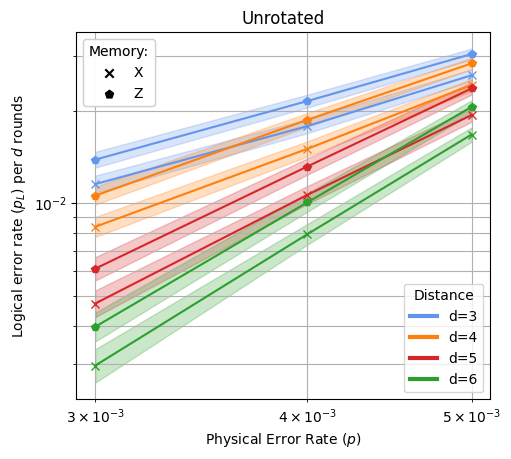

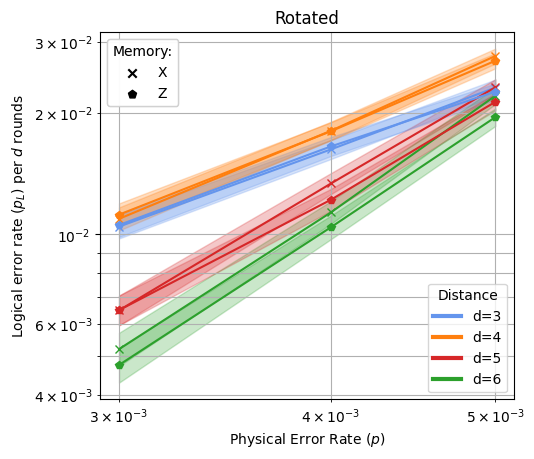

In [17]:
# python:
reload(funcs)

mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')

funcs.plot_thresholds(mylist, ro_CNOT_order, unro_CNOT_order) # note different y-axis scalings

##### Fit to scaling function $p_L = \alpha ( p / \beta)^{\gamma d - \delta}$

<IPython.core.display.Math object>


distances = combined

unro z 10231203

    α = 0.044 ± 0.008
    β = 0.00633 ± 0.00002
    γ = 0.573 ± 0.048
    δ = 0.24 ± 0.22


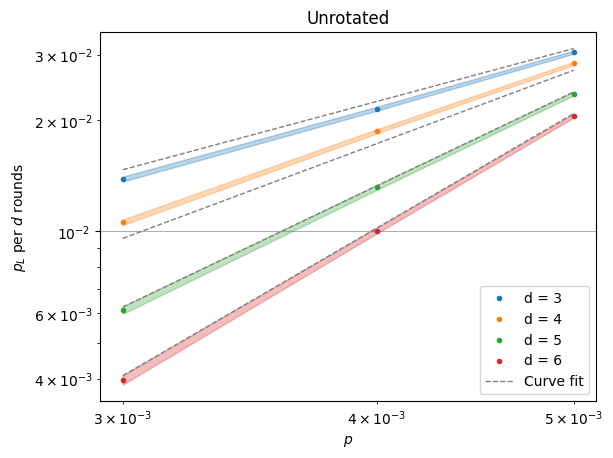


ro z 32013021

    α = 0.031 ± 0.008
    β = 0.00589 ± 0.00016
    γ = 0.443 ± 0.061
    δ = -0.08 ± 0.28


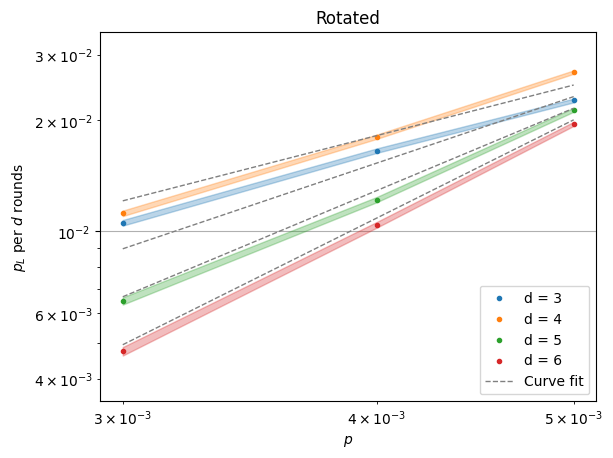

In [18]:
reload(funcs)
distances = 'combined' # choices are 'odd', 'even' or 'combined'
b = 'z' # choices are x or z 



funcs.fit_scaling_and_plot(mylist, distances, b, ro_CNOT_order, unro_CNOT_order, minp = min(noise), maxp = max(noise))

##### Plot as $p_L$ vs. $\sqrt{n}$

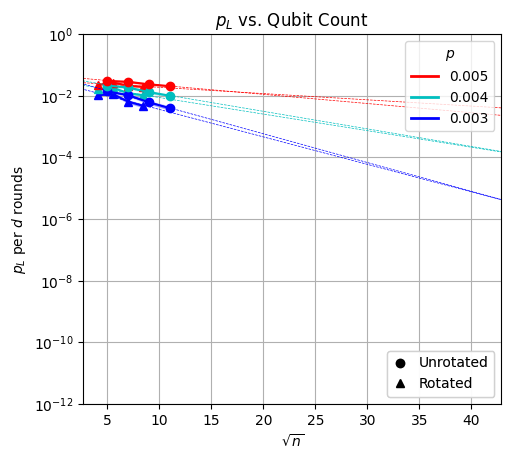

In [19]:
reload(funcs)

b = 'z' 

mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')
# 
funcs.plot_pL_vs_qubit_count(mylist, b, ro_CNOT_order, unro_CNOT_order)

##### Plot 'teraquop' count :$\ $ the number of qubits required to reach $p_L = 10^{-12}$

<IPython.core.display.Math object>

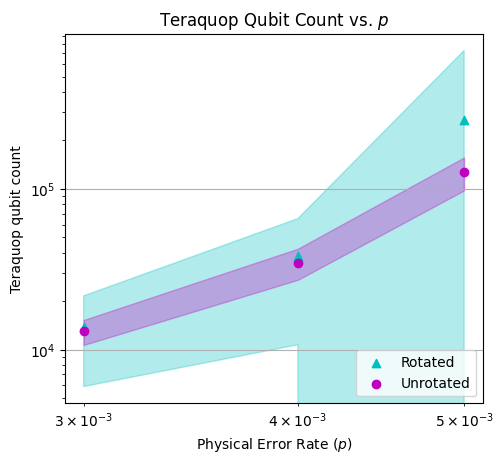

In [20]:
funcs.plot_teraquop(mylist, b, ro_CNOT_order, unro_CNOT_order, optional_plot = False)

##### Plot ratios of qubit counts vs. $p_L$

This is the projected number of qubits used by the rotated surface code divided by the number of qubits used by the unrotated surface code to achieve the same $p_L$

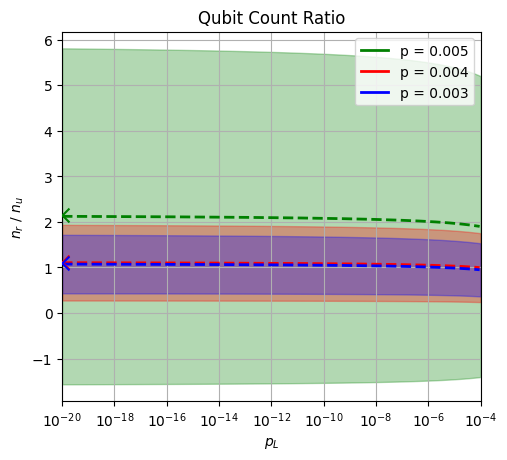

In [21]:
reload(funcs)

funcs.plot_ratio(mylist, b, ro_CNOT_order, unro_CNOT_order)

##### Memory time vs. $\sqrt{n}$

This is a reformulation of the $p_L$ vs. $\sqrt{n}$ plots above, converting the $p_L$ per $d$ rounds to be the length of time (assuming one stabiliser measurement cycle take a microsecond) before $p_L$ over the entire shot of the memory experiment equals $p$.

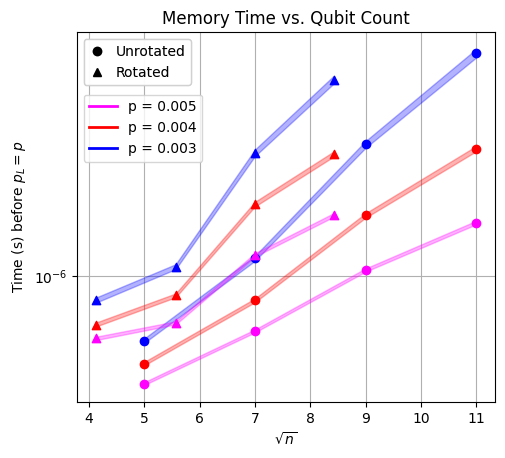

In [22]:
funcs.plot_memory_times(mylist, b, ro_CNOT_order, unro_CNOT_order)